# Read and Cluster Mill Data
04 Dec 2023: John A. Thompson (Information Professionals GmbH)

Processing:
  - 1
  - 2

In [ ]:
# Set up environment.

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

sns.set(context='notebook', font='monospace')


In [50]:
# Define params.

FNAME =  './mill.csv'

In [51]:
df = pd.read_csv(FNAME, sep=';', dtype={'Sorte': object})

In [52]:
df

,Sorte,ZM,Datum,Betriebszeit,Gesamtenergie,Produktion,kWh/t,t/h
0,01,ZMA,2021-02-09 00:00:00,3.82,10639.81,372.20,28.586271,97.434555
1,01,ZMA,2021-02-17 00:00:00,17.29,24280.89,858.17,28.293800,49.633892
2,01,ZMA,2021-02-18 00:00:00,0.00,0.00,0.00,NaN,NaN
3,01,ZMA,2021-07-16 00:00:00,1.61,2212.74,68.62,32.246284,42.621118
4,01,ZMA,2021-07-29 00:00:00,1.47,1960.19,62.97,31.128950,42.836735
...,...,...,...,...,...,...,...,...
4546,04,ZMC,2022-11-28 00:00:00,20.08,11956.19,287.21,41.628739,14.303287
4547,04,ZMC,2022-11-29 00:00:00,24.00,14245.37,338.76,42.051511,14.115000
4548,04,ZMC,2022-11-30 00:00:00,22.30,13235.85,324.15,40.832485,14.535874
4549,04,ZMC,2022-12-01 00:00:00,0.43,257.95,5.56,46.393885,12.930233


In [53]:
df.Betriebszeit.max()

38.48

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


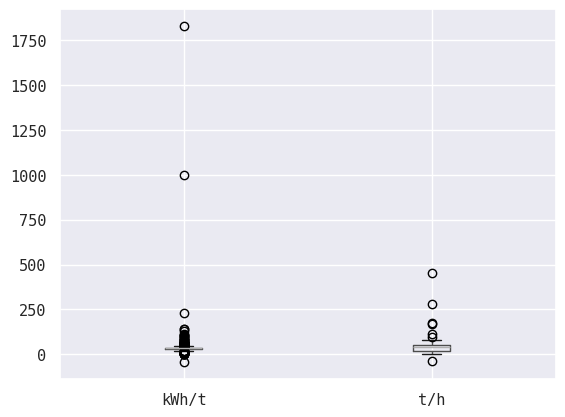

In [ ]:
# Plot boxplots for the numeric columns
df[['kWh/t', 't/h']].boxplot()
plt.show()


In [ ]:
#looking for outliers 

def find_outliers_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile range

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify rows that are outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers_kwh_t = find_outliers_iqr(df, 'kWh/t')
outliers_t_h = find_outliers_iqr(df, 't/h')

# Combine outliers for inspection
all_outliers = pd.concat([outliers_kwh_t, outliers_t_h]).drop_duplicates()
print(all_outliers)

#removing outliers for kWh/t and t/h since not sure if others can be wrong values 
df_cleaned = df.drop(all_outliers.index)
print(df_cleaned)


     Sorte   ZM                Datum  Betriebszeit  Gesamtenergie  Produktion  \
32      01  ZMA  2021-09-19 00:00:00         24.00       32483.44      694.85   
101     01  ZMA  2021-12-21 00:00:00          3.75        5326.75       67.04   
149     01  ZMA  2022-04-19 00:00:00          0.14         171.34        3.14   
190     01  ZMA  2022-06-13 00:00:00          0.39         476.11        5.75   
289     01  ZMA  2022-10-04 00:00:00          0.47         565.61        9.83   
...    ...  ...                  ...           ...            ...         ...   
4385    04  ZMC  2021-09-20 00:00:00          0.74         422.42        7.74   
4412    04  ZMC  2022-01-25 00:00:00          0.08          54.08        0.00   
4427    04  ZMC  2022-03-13 00:00:00          0.83         519.89       11.19   
0       01  ZMA  2021-02-09 00:00:00          3.82       10639.81      372.20   
4084    04  ZMB  2021-03-28 00:00:00          0.00        1247.86       44.13   

          kWh/t        t/h 

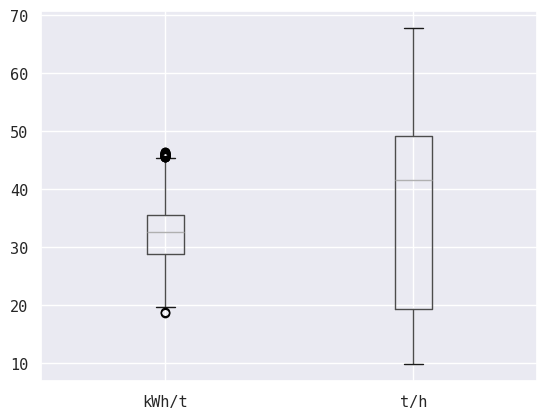

In [ ]:
#checking what the data looks like now
df_cleaned[['kWh/t', 't/h']].boxplot()
plt.show()


In [ ]:
#checking if there are null values 
print(df_cleaned.isnull().sum())


Sorte              0
ZM                 0
Datum              0
Betriebszeit       0
Gesamtenergie      0
Produktion         0
kWh/t            354
t/h              354
dtype: int64


In [ ]:
#too many columns with missed data, do not want to delete the whole tuples, will fill them in with the mean value per column 
columns_to_fill = ['kWh/t', 't/h']  # Columns with null values

for column in columns_to_fill:
    df_cleaned[column] = df_cleaned[column].fillna(df_cleaned[column].mean())
    

In [ ]:
print(df_cleaned.isnull().sum())


Sorte            0
ZM               0
Datum            0
Betriebszeit     0
Gesamtenergie    0
Produktion       0
kWh/t            0
t/h              0
dtype: int64


In [ ]:
cluster_cols = ['Gesamtenergie', 'Produktion', 'kWh/t', 't/h']
cluster_df = df_cleaned[cluster_cols].replace({np.inf: np.NaN, -np.inf:np.NaN}).dropna()


In [ ]:
#standardising the data

numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cleaned[numeric_columns])

# Convert scaled data back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numeric_columns)

# If needed, combine scaled numeric data with non-numeric columns
non_numeric_columns = df_cleaned.select_dtypes(exclude=['float64', 'int64'])
final_df = pd.concat([scaled_df, non_numeric_columns.reset_index(drop=True)], axis=1)

# Display the resulting DataFrame
print(final_df)


      Betriebszeit  Gesamtenergie  Produktion         kWh/t       t/h Sorte  \
0         0.562531       0.732956    0.875926 -9.782584e-01  0.875744    01   
1        -1.432035      -1.239840   -1.184236 -1.629659e-15  0.000000    01   
2        -1.246306      -1.060057   -1.019503 -7.173976e-02  0.370450    01   
3        -1.262456      -1.080576   -1.033067 -3.280049e-01  0.385986    01   
4         1.185473       1.244281    1.047116  7.678821e-02  0.251070    01   
...            ...            ...         ...           ...       ...   ...   
4338      0.884384      -0.268412   -0.494746  2.080165e+00 -1.669948    04   
4339      1.336594      -0.082419   -0.370993  2.177130e+00 -1.683515    04   
4340      1.140483      -0.164441   -0.406066  1.897541e+00 -1.653190    04   
4341     -1.382430      -1.218881   -1.170888  3.173071e+00 -1.768882    04   
4342     -1.365126      -1.211647   -1.164142  2.040637e+00 -1.660744    04   

       ZM                Datum  
0     ZMA  2021-02

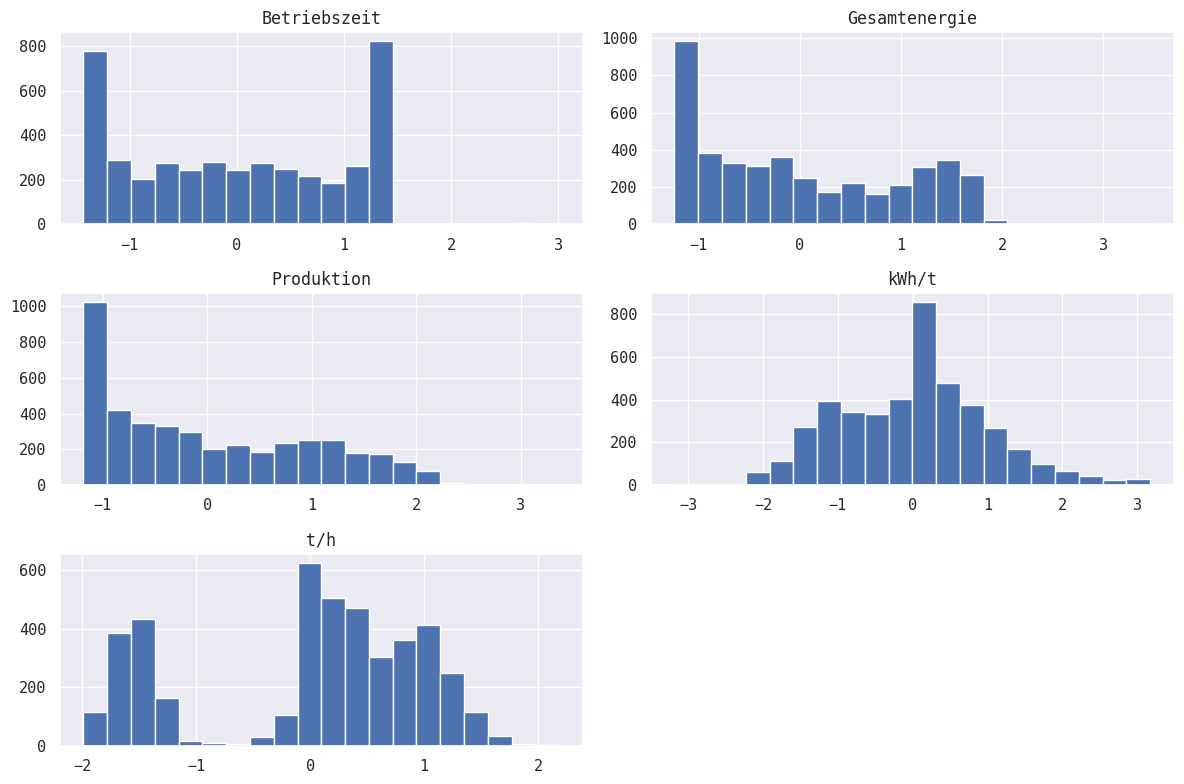

In [ ]:
final_df.hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()


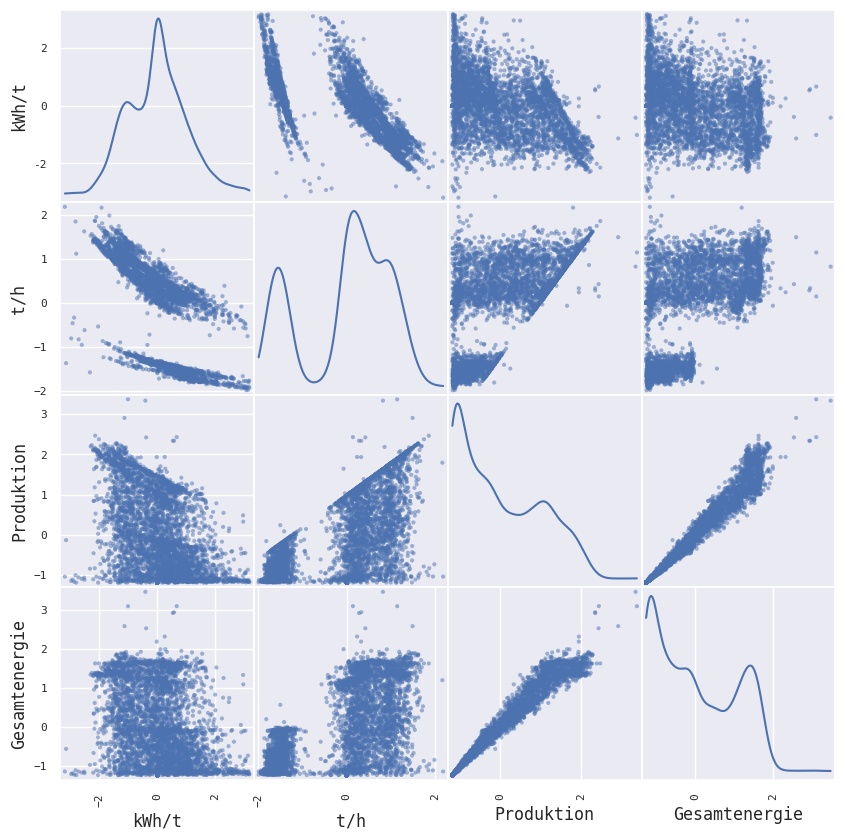

In [ ]:
columns_to_plot = ['kWh/t', 't/h', 'Produktion', 'Gesamtenergie']  # Select relevant columns

# Create scatter matrix
pd.plotting.scatter_matrix(final_df[columns_to_plot], figsize=(10, 10), diagonal='kde')
plt.show()


## Agglomerative Clustering

In [ ]:
cluster_cols = ['Gesamtenergie', 'Produktion', 'kWh/t', 't/h']
cluster_df = final_df[cluster_cols].replace({np.inf: np.NaN, -np.inf:np.NaN}).dropna()


In [ ]:
n_clusters = 6
agg_clusters = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(cluster_df.values)


In [ ]:
pd.value_counts(agg_clusters).sort_index()


/var/folders/47/89r0q_610kjbhc1dbtxcw1m00000gn/T/ipykernel_56970/4210025347.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(agg_clusters).sort_index()


0    1122
1     841
2     520
3     721
4     591
5     548
Name: count, dtype: int64

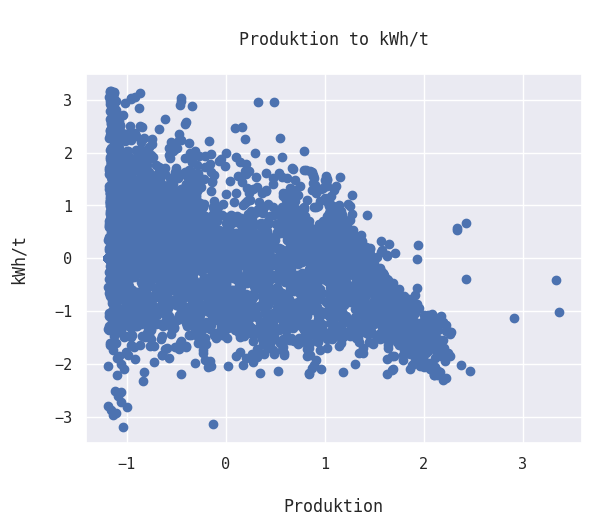

In [ ]:
x_axis = 'Produktion'
y_axis = 'kWh/t'
plt.title('\n{} to {}\n'.format(x_axis, y_axis))
plt.xlabel('\n{}'.format(x_axis))
plt.ylabel('{}\n'.format(y_axis))
plt.scatter(cluster_df[x_axis], cluster_df[y_axis])
plt.show()


In [ ]:
limits = {
    'Gesamtenergie': (0, max(cluster_df["Gesamtenergie"])),
    'Produktion': (0, max(cluster_df["Produktion"])),
    'kWh/t': (0, max(cluster_df["kWh/t"])),
    't/h': (0, max(cluster_df["t/h"]))
}
charts = [
    ('Gesamtenergie', 't/h'),
    ('Produktion', 't/h'),
    ('kWh/t', 't/h'),
    ('Gesamtenergie', 'kWh/t'),
    ('Produktion', 'kWh/t'),
    ('Gesamtenergie', 'Produktion')
]


/var/folders/47/89r0q_610kjbhc1dbtxcw1m00000gn/T/ipykernel_56970/2006963542.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('seismic', n_clusters)    # n discrete colors


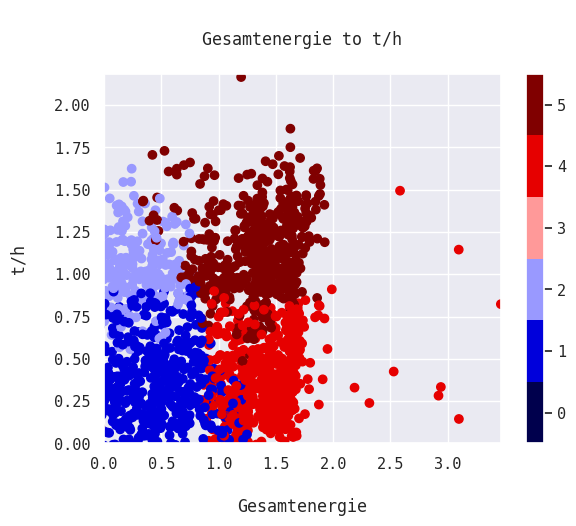

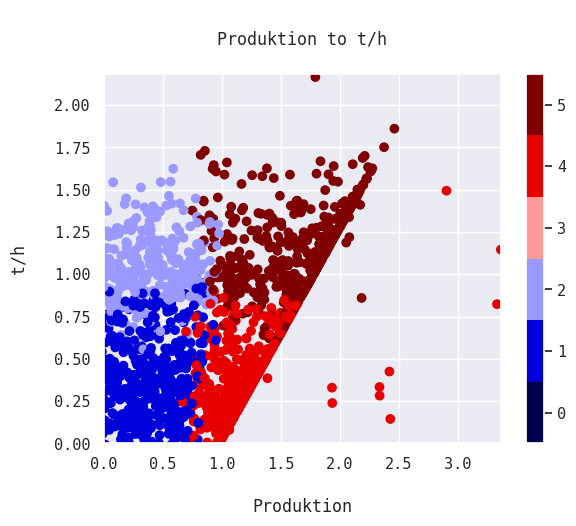

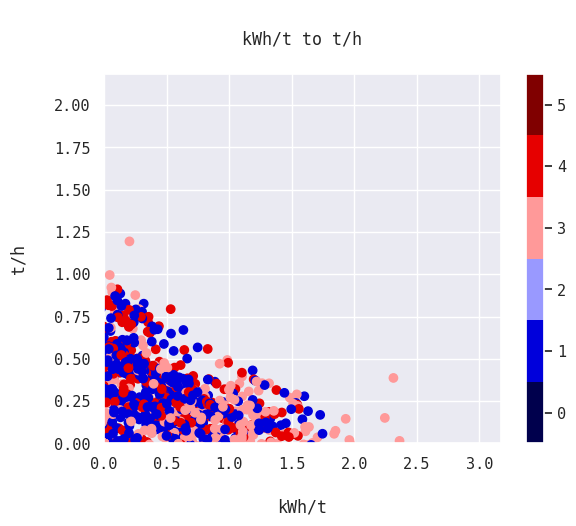

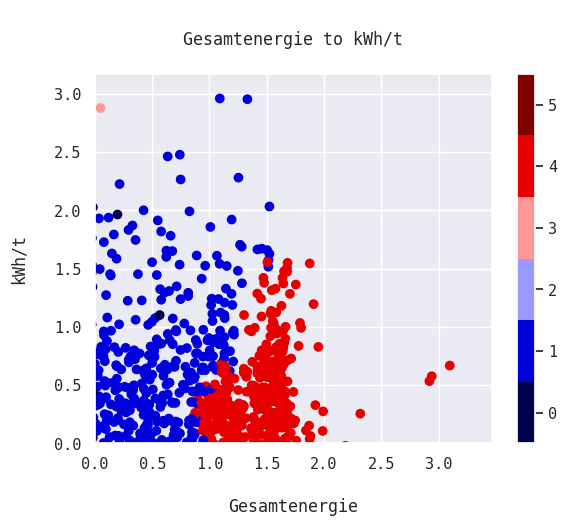

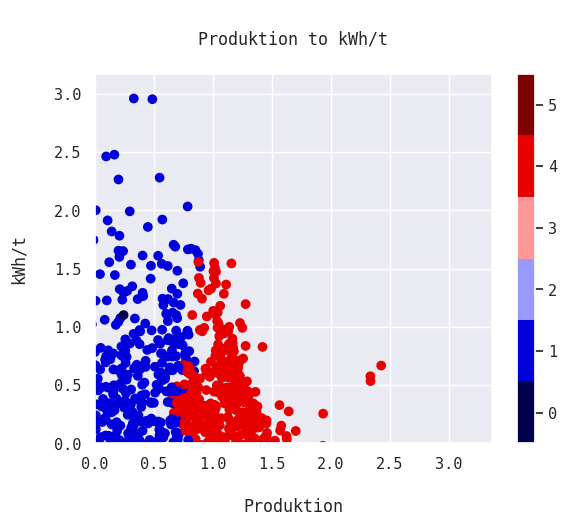

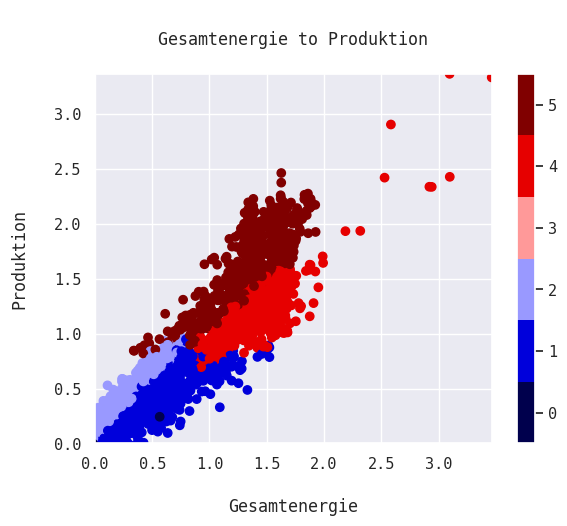

In [ ]:
colors = agg_clusters
cmap = plt.cm.get_cmap('seismic', n_clusters)    # n discrete colors

for x_axis, y_axis in charts:
    plt.title('\n{} to {}\n'.format(x_axis, y_axis))
    plt.xlabel('\n{}'.format(x_axis))
    plt.ylabel('{}\n'.format(y_axis))
    plt.scatter(cluster_df[x_axis], cluster_df[y_axis], c=colors, cmap=cmap)
    plt.xlim(limits[x_axis])
    plt.ylim(limits[y_axis])
    cbar = plt.colorbar(ticks=np.array(range(n_clusters)))
    plt.clim(-0.5, n_clusters-0.5)
    plt.show()
    